In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.optimize import newton, brenth
import math

### Keratinocyte-Neutrophil system at high oxygen 

First subsystem of interest is neutrophils and keratinocyte, not too special steady states without oxygen.


In [2]:
# get nullcline curves, this is at high oxygen, just neutrophils and keratinocytes

def nullcline_rhok(rhok,rhon,param):
    p_k = param[0]
    lkTa = param[1]
    d_k = param[2]
    
    return rhok*(p_k*(1.0-0.5*rhok)-d_k*(lkTa*Hill(rhon,0.5,3)+1))

def nullcline_rhon(rhon,rhok,param):
    p_a = param[0]
    lkTa = param[1]
    d_a = param[2]
    p_n = param[3]
    lnDa = param[4]
    d_n = param[5]
    
    Da = p_a*rhok*(Hsu1(rhon,0.5,3,lkTa)-1.0)/d_a
    
    return p_n*rhon*(lnDa*Hill(Da,0.3,3)+1.0)*(1.0-0.5*rhon)-d_n*rhon

In [3]:
# other functions

# Standard Hill function
def Hill(X,X0,nX):
    return X**nX/(X0**nX+X**nX)
# Heviside function
def Hev(X,X0,k):
    return 1.0/(1.0+np.exp(-2.0*k*(X-X0)))
# Hill function shifted up by 1
def Hsu1(X,X0,nX,lamb):
    if X>0.0:
        return lamb + (1.0-lamb)/(1.0 + (X/X0)**nX)
    else:
        return 1.0

# G function is a by-product of Hill
def Gh(X,X0,nX,lamb):
    return (lamb-1.0)*(1.0-Hill(X,X0,nX))+1.0
# Hi function is a by product of Hsu1
def Hi(X,X0,nX,lamb):
    return Hsu1(X-1.0,X0-1.0,nX,lamb)

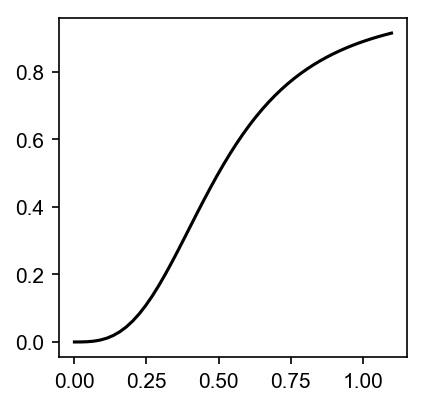

In [4]:
## Plot the Hill function
Ta_vec_test = np.linspace(0,1.1,50)
Hi_vec_test = np.zeros((50))
for i in range(50):
    Hi_vec_test[i] = Hill(Ta_vec_test[i],0.5,3)
plt.figure(figsize=(3,3),dpi=150)    
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=9)
ax = plt.subplot(111)    
ax.plot(Ta_vec_test,Hi_vec_test,color='black')
plt.savefig('june2018_hill.png')

In [5]:
# these parameters are fixed
p_k =  0.028
d_k = 0.5*p_k # 1/hr
d_a = 0.144
p_a = 0.23
p_n = 0.1427
d_n = 0.141

# these parameters can be adjusted
lnDa = 0.5
lkTa = 0.3

param_nc1 = [p_k,lkTa,d_k]
param_nc2 = [p_a,lkTa,d_a,p_n,lnDa,d_n]

In [6]:
## compute the nullclines
npts = 200
rhon_ls = np.linspace(0.0,1.1,npts)
rhok_ls = np.linspace(0.0,1.1,npts)
nc1_pts = np.zeros((npts))
#nc3_pts = np.zeros((npts))
nc2_pts = np.zeros((npts))
for i in range(npts):
    nc1_pts[i] = newton(nullcline_rhok, 1.1, args=(rhon_ls[i],param_nc1))
    #nc3_pts[i] = newton(nullcline_rhok, 0.001, args=(rhon_ls[i],param_nc1))
    nc2_pts[i] = newton(nullcline_rhon, 0.05,  args=(rhok_ls[i],param_nc2))
    #print(res1,rhon_ls[i]).0
## get the intersection of the two nullclines
dmin = 1e6
for i in range(npts):
    for j in range(npts):
        if (nc1_pts[i]-rhok_ls[j])**2+(nc2_pts[j]-rhon_ls[i])**2<dmin:
            intersection = (rhon_ls[i],rhok_ls[j])
            dmin = (nc1_pts[i]-rhok_ls[j])**2+(nc2_pts[j]-rhon_ls[i])**2
print(intersection)

(0.022110552763819097, 1.0005025125628142)


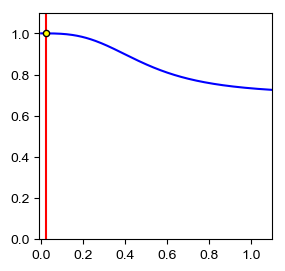

In [7]:
#cmap = matplotlib.cm.get_cmap('jet', n_theta)  
plt.figure(figsize=(3,3),dpi=100)    
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=9)
ax = plt.subplot(111)    
#for i in range(n_theta):
#    ax.plot(time_ls,thetag_mat[n_theta-i-1],'-',color = cmap(i),linewidth='1.5',label="th=%.1f"%theta_ls[n_theta-i-1])
ax.plot(rhon_ls,nc1_pts,'-',color = "blue",linewidth='1.5',zorder=0)
#ax.plot(rhon_ls,nc3_pts,'-',color = "blue",linewidth='1.5')
ax.plot(nc2_pts,rhok_ls,'-',color = "red",linewidth='1.5',zorder=1)
ax.scatter(intersection[0],intersection[1],color='yellow',s=20,edgecolors='black',zorder=2)
#ax.scatter(intersection_points[:,0],intersection_points[:,1],color='grey',s=4)
ax.set_xlim([-0.01,1.1])
ax.set_ylim([0,1.1])
#ax.set_xlabel('rhon')
#ax.set_ylabel('rhok')
ax.xaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
#ax.set_title('thetag')
#ax.legend(loc=2)
plt.savefig('june2018_kn_simplest.png')

### Neutrophil-Keratinocyte system with constant oxygen 

First we just define the extended system. This extended system includes the oxygen as an input, but ignores IR cycles. After we define the new steady state equations we do a variation of the oxygen values to see the effect on rho_k and rho_n. Then we change the parameter related to recruitment by Damps. 

In [8]:
# get nullcline curves

def nullcline_rhok(rhok,rhon,param):
    p_k = param[0]
    lkTa = param[1]
    d_k = param[2]
    O2 = param[3]
    lkR = param[4]
    pRn = param[5]
    dR = param[6]
    ## assuming steady state for ROS to get nullclines of rhok and rhon only
    ROS = pRn*Hill(O2,0.6,4)*rhon/dR+0.0127/dR # from XO
    return (p_k*(1-0.5*rhok)*Hill(O2,0.2,4.0)-d_k*(lkTa*Hill(rhon,0.5,3)+lkR*Hill(ROS,0.5,3)+1.0))*rhok

def nullcline_rhon(rhon,rhok,param):
    p_a = param[0]
    lkTa = param[1]
    d_a = param[2]
    p_n = param[3]
    lnDa = param[4]
    d_n = param[5]
    lnKC = param[6]
    lkR = param[7]
    pRn = param[8]
    dR = param[9]
    O2 = param[10]
    
    ROS = pRn*Hill(O2,0.6,4)*rhon/dR+0.0127/dR # from XO
    Da = p_a*rhok*(lkTa*Hill(rhon,0.5,3)+lkR*Hill(ROS,0.5,3))/d_a
    KC = (Hill(1.0-O2,0.4,3))*rhok
    
    return p_n*(lnDa*Hill(Da,0.3,3)+lnKC*Hill(KC,0.5,3)+1)*(1-0.5*rhon)*rhon-d_n*rhon

In [9]:
# these parameters are fixed
p_k =  0.028
d_k = 0.5*p_k
p_a = 0.23
d_a = 0.144
p_n = 0.1427
d_n = 0.141
pRn =  0.036
dR = 0.084

# these parameters can be adjusted
lnDa = 0.5
lkTa = 0.3
lkR = 0.4
lnKC = 0.5

# this is the input variable
O2 = 0.654
    
param_ncrhok = [p_k,lkTa,d_k,O2,lkR,pRn,dR]
param_ncrhon= [p_a,lkTa,d_a,p_n,lnDa,d_n,lnKC,lkR,pRn,dR,O2]

In [10]:
ox_vec

NameError: name 'ox_vec' is not defined

In [11]:
## For high oxygen but with ROS, the curve should look a little different from the previous one
## Also, to check the two ways of plotting with contour and with Newton 

## CONTOURs
delta = 0.003
rhok = np.arange(0.003, 1.05, delta)
rhon = np.arange(0.003, 1.0, delta)
nrk = len(rhok)
nrn = len(rhon)
Rn, Rk = np.meshgrid(rhon, rhok)
NC1mg = np.zeros((nrk,nrn))
NC2mg = np.zeros((nrk,nrn))
dmin = 1e6
nint = 0
for i in range(nrk):
    for j in range(nrn):
        NC1mg[i,j] = nullcline_rhok(Rk[i,j],Rn[i,j],param_ncrhok)
        NC2mg[i,j] = nullcline_rhon(Rn[i,j],Rk[i,j],param_ncrhon)
        ## try to get the intersection point
        ## both of the points should be zero, let's try to get the smallest
        ##print(NC1[i,j]**2 + NC2[i,j]**2)
        if NC1mg[i,j]**2 + NC2mg[i,j]**2<dmin:
            intersection = (Rn[i,j],Rk[i,j])
            dmin = NC1mg[i,j]**2 + NC2mg[i,j]**2
            #print('at ', rhon[j],rhok[i])
print('intersection with contours', intersection)

## NEWTON
delta = 0.01
rhok_ls = np.arange(0.001, 1.1, delta)
rhon_ls = np.arange(0.001, 1.0, delta)
nrk = len(rhok_ls)
nrn = len(rhon_ls)
NC1 = np.zeros((nrn))
NC2 = np.zeros((nrk))
for i in range(nrn):
    NC1[i] = newton(nullcline_rhok, 1.5, args=(rhon_ls[i],param_ncrhok),maxiter=1000)
for i in range(nrk):
    NC2[i] = newton(nullcline_rhon, 0.6,  args=(rhok_ls[i],param_ncrhon),maxiter=1000)
intersection = (-1,-1)
dmin = 1e6
for i in range(nrn):
    for j in range(nrk):
        if (NC1[i]-rhok_ls[j])**2+(NC2[j]-rhon_ls[i])**2<dmin:
            intersection = (rhon_ls[i],rhok_ls[j])
            dmin = (NC1[i]-rhok_ls[j])**2+(NC2[j]-rhon_ls[i])**2
print('intersection with newton', intersection)

intersection with contours (0.312, 0.897)


RuntimeError: Failed to converge after 1000 iterations, value is 0.4006826871921017

In [12]:
## Plot side by side to check
plt.figure(figsize=(7,3),dpi=100)    
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=9)
ax = plt.subplot(121)    
ax.plot(rhon_ls,NC1,'-',color = "blue",linewidth='1.5')
ax.plot(NC2,rhok_ls,'-',color = "red",linewidth='1.5')
ax.set_xlabel('rhon')
ax.set_ylabel('rhok')
ax.set_xlim([-0.01,1.1])
ax.set_ylim([0,1.1])
ax.xaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_title('newton')

ax = plt.subplot(122)    
ax.contour(Rn, Rk, NC1mg,levels=[0],colors='blue',linewidth=1.5)
ax.contour(Rn, Rk, NC2mg,levels=[0],colors='red',linewidth=1.5)
ax.set_xlabel('rhon')
ax.set_ylabel('rhok')
ax.set_xlim([-0.01,1.1])
ax.set_ylim([0,1.1])
ax.xaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_title('zero level contour')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Text(0.5,1,'zero level contour')

### Steady state as a function of Oxygen

Change the oxygen value, decreasting it slowly in order to get the steady state as a function of oxygen, no oscillations 

In [13]:
# define functions for interesection with contour or newton intersection 
def getIntersectionNewton(param_ncrhok,param_ncrhon,initk,initn):
    delta = 0.01
    rhok_ls = np.arange(0.001, 1.1, delta)
    rhon_ls = np.arange(0.001, 1.0, delta)
    nrk = len(rhok_ls)
    nrn = len(rhon_ls)
    NC1 = np.zeros((nrn))
    NC2 = np.zeros((nrk))
    for i in range(nrn):
        NC1[i] = newton(nullcline_rhok, x0=initk, args=(rhon_ls[i],param_ncrhok),tol=1e-14,maxiter=1900)
    for i in range(nrk):
        NC2[i] = newton(nullcline_rhon, x0=initn,  args=(rhok_ls[i],param_ncrhon),tol=1e-14,maxiter=1900)
    intersection = (-1,-1)
    dmin = 1e6
    for i in range(nrn):
        for j in range(nrk):
            if (NC1[i]-rhok_ls[j])**2+(NC2[j]-rhon_ls[i])**2<dmin and Rn[i,j]+Rk[i,j]>0.01:
                intersection = (rhon_ls[i],rhok_ls[j])
                dmin = (NC1[i]-rhok_ls[j])**2+(NC2[j]-rhon_ls[i])**2
    #print('intersection with newton', intersection)
    return intersection 

def getIntersectionContour(param_ncrhok,param_ncrhon):
    delta = 0.001
    rhok = np.arange(0.01, 1.05, delta)
    rhon = np.arange(0.01, 1.0, delta)
    nrk = len(rhok)
    nrn = len(rhon)
    Rn, Rk = np.meshgrid(rhon, rhok)
    NC1mg = np.zeros((nrk,nrn))
    NC2mg = np.zeros((nrk,nrn))
    dmin = 1e6
    tol1 = 1e-8
    tol2 = 0.05
    nint = 0
    intersection = (-1,-1)
    intersections = []
    for i in range(nrk):
        for j in range(nrn):
            NC1mg[i,j] = nullcline_rhok(Rk[i,j],Rn[i,j],param_ncrhok)
            NC2mg[i,j] = nullcline_rhon(Rn[i,j],Rk[i,j],param_ncrhon)
            ## try to get the intersection points
            ## both of the NC points should be zero
            if NC1mg[i,j]**2 + NC2mg[i,j]**2 <tol1:
                #print('at ', rhon[j],rhok[i])
                if nint==0:
                    # first intersection
                    intersection = (Rn[i,j],Rk[i,j])
                    intersections.append(intersection)
                    nint = 1
                else:
                    # check if this point is very close to the previous one,
                    # if it is more than some distance away then it should be a different
                    # branch
                    if (Rn[i,j]-intersection[0])**2+(Rk[i,j]-intersection[1])**2<tol2:
                        if NC1mg[i,j]**2 + NC2mg[i,j]**2<dmin:
                            intersection = (Rn[i,j],Rk[i,j])
                            dmin = NC1mg[i,j]**2 + NC2mg[i,j]**2
                            intersections[nint-1] = intersection
                    else:
                        intersection = (Rn[i,j],Rk[i,j])
                        intersections.append(intersection)
                        dmin = 1e6
                        nint +=1
                    
    #print('intersection with contours', intersections, 'dmin', dmin)
    return nint,intersections

def getContours(param_ncrhok,param_ncrhon):
    delta = 0.002
    rhok = np.arange(0.01, 1.05, delta)
    rhon = np.arange(0.01, 1.0, delta)
    nrk = len(rhok)
    nrn = len(rhon)
    Rn, Rk = np.meshgrid(rhon, rhok)
    NC1mg = np.zeros((nrk,nrn))
    NC2mg = np.zeros((nrk,nrn))
    dmin = 1e6
    tol1 = 1e-8
    tol2 = 0.1
    nint = 0
    intersection = (-1,-1)
    intersections = []
    for i in range(nrk):
        for j in range(nrn):
            NC1mg[i,j] = nullcline_rhok(Rk[i,j],Rn[i,j],param_ncrhok)
            NC2mg[i,j] = nullcline_rhon(Rn[i,j],Rk[i,j],param_ncrhon)
    return Rn,Rk,NC1mg,NC2mg

In [14]:
## LOOP OVER OXYGEN
ox_vec = np.linspace(0.2,0.999,30)
intersect_vec = np.zeros((30,2))
for i in range(30):
    if i==0:
        initk = 0.01
        initn = 0.01
    elif i>1:
        initn = intersect_vec[i-1,0]
        initk = intersect_vec[i-1,1]
    Ox = ox_vec[i]
    #print('Ox=',Ox)
    param_ncrhok = [p_k,lkTa,d_k,Ox,lkR,pRn,dR]
    param_ncrhon= [p_a,lkTa,d_a,p_n,lnDa,d_n,lnKC,lkR,pRn,dR,Ox]
    #intersection = getIntersectionNewton(param_ncrhok,param_ncrhon,initk,initn)
    nint,intersections = getIntersectionContour(param_ncrhok,param_ncrhon)
    print('n intersections',nint)
    if nint>1:
        print(intersections)
    intersect_vec[i,0] = intersections[nint-1][0]
    intersect_vec[i,1] = intersections[nint-1][1]

n intersections 1


KeyboardInterrupt: 

In [ ]:
#cmap = matplotlib.cm.get_cmap('jet', n_theta)  
plt.figure(figsize=(3,3),dpi=100)    
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=9)
ax = plt.subplot(111)    

ax.plot(intersect_vec[:,0],intersect_vec[:,1],'-o',color = "black",linewidth='1.5',zorder=1,markersize=2)
ax.scatter(intersect_vec[:,0],intersect_vec[:,1],color='yellow',s=20,edgecolors='black',zorder=2)
ax.set_xlim([0,1.1])
ax.set_ylim([-0.1,1.1])
ax.xaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
plt.savefig('june2018_kn_oxygen_SS.png')

In [ ]:
plt.figure(figsize=(3,3),dpi=100)    
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=9)
ax = plt.subplot(111)    

ax.plot(ox_vec,intersect_vec[:,0],color = "red",linewidth='1.5',zorder=1)
ax.plot(ox_vec,intersect_vec[:,1],color = "blue",linewidth='1.5',zorder=1)
plt.savefig('june2018_kn_oxygen_SSv2.png')

### Sensitivity of the Damps parameter

we change lambda_Da in the Hill function of neutrophil recruitment to see the effect of this variable on the system behavior

In [16]:
## LOOP OVER lDan
lDan_vec = np.linspace(0.3,0.7,5)
ox_vec = np.linspace(0.2,0.999,50)
intersect_vec = np.zeros((5,50,4))
for j in range(0,5):
    lnDa = lDan_vec[j]
    print('lnDa=',lnDa)
    for i in range(50):
        if i==0:
            initk = 0.5
            initn = 0.5
        elif i>1:
            initn = intersect_vec[j,i-1,0]
            initk = intersect_vec[j,i-1,1]
        Ox = ox_vec[i]
        #print('Ox=',Ox)
        param_ncrhok = [p_k,lkTa,d_k,Ox,lkR,pRn,dR]
        param_ncrhon= [p_a,lkTa,d_a,p_n,lnDa,d_n,lnKC,lkR,pRn,dR,Ox]
        #intersection = getIntersectionNewton(param_ncrhok,param_ncrhon,initk,initn)
        nint, intersections = getIntersectionContour(param_ncrhok,param_ncrhon)
        if nint>0:
            print(Ox,nint,intersections)
        intersect_vec[j,i,0] = intersections[nint-1][0]
        intersect_vec[j,i,1] = intersections[nint-1][1]
        ROS = pRn*Hill(Ox,0.6,4)*intersection[0]/dR+0.0127/dR
        intersect_vec[j,i,2] = ROS
        intersect_vec[j,i,3] = p_a*intersection[1]*(lkTa*Hill(intersection[0],0.6,3)+lkR*Hill(ROS,0.6,3))/d_a

lnDa= 0.3
0.2 1 [(0.023999999999999987, 0.01)]
0.2163061224489796 2 [(0.023999999999999987, 0.01), (0.09599999999999992, 0.2459999999999998)]
0.23261224489795918 2 [(0.023999999999999987, 0.01), (0.23699999999999982, 0.3899999999999997)]
0.24891836734693878 2 [(0.023999999999999987, 0.01), (0.32699999999999974, 0.47399999999999964)]
0.2652244897959184 2 [(0.023999999999999987, 0.01), (0.3899999999999997, 0.5339999999999996)]
0.28153061224489795 2 [(0.023999999999999987, 0.01), (0.43599999999999967, 0.5779999999999995)]
0.29783673469387756 2 [(0.023999999999999987, 0.01), (0.47399999999999964, 0.6129999999999995)]
0.31414285714285717 2 [(0.023999999999999987, 0.01), (0.5059999999999996, 0.6419999999999995)]
0.3304489795918367 1 [(0.5289999999999996, 0.6639999999999995)]
0.3467551020408163 1 [(0.5459999999999996, 0.6819999999999995)]
0.3630612244897959 1 [(0.5589999999999995, 0.6969999999999994)]
0.3793673469387755 1 [(0.5669999999999995, 0.7089999999999994)]
0.39567346938775505 1 [(0.57

KeyboardInterrupt: 

In [95]:
plt.figure(figsize=(3,3),dpi=100)    
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=9)
ax = plt.subplot(111)    
for j in range(5):
    hexcolor1 = "#%02x%02x%02x" % (255,int(255*j/7.0),int(255*j/7.0))
    hexcolor2 = "#%02x%02x%02x" % (int(255*j/7.0),int(255*j/7.0),255)
    ax.plot(ox_vec,intersect_vec[j,:,0],color = hexcolor1,linewidth='1.5',zorder=10-j)
    ax.plot(ox_vec,intersect_vec[j,:,1],color = hexcolor2,linewidth='1.5',zorder=10-j)
plt.savefig('june2018_kn_oxygen_lnDa.png')

In [97]:
## Find all intersections for lnDa = 1, Ox = 0.99
Ox = 0.99
lnDa = 1.0
param_ncrhok = [p_k,lkTa,d_k,Ox,lkR,pRn,dR]
param_ncrhon= [p_a,lkTa,d_a,p_n,lnDa,d_n,lnKC,lkR,pRn,dR,Ox]
nint, intersections = getIntersectionContour(param_ncrhok,param_ncrhon)
print(nint,intersections)

(3, [(0.82699999999999929, 0.57499999999999951), (0.3469999999999997, 0.86099999999999932), (0.021999999999999992, 0.98599999999999921)])


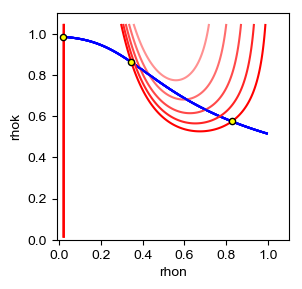

In [99]:
## Need to generate contours on the phase space
## LOOP OVER lDan
lDan_vec = np.linspace(0.6,1.0,5)
## keep Ox at maximum 
Ox = 0.99

plt.figure(figsize=(3,3),dpi=100)    
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=9)
ax = plt.subplot(111)    

for j in range(0,5):
    lnDa = lDan_vec[4-j]
    param_ncrhok = [p_k,lkTa,d_k,Ox,lkR,pRn,dR]
    param_ncrhon= [p_a,lkTa,d_a,p_n,lnDa,d_n,lnKC,lkR,pRn,dR,Ox]
    Rn,Rk,NC1mg,NC2mg = getContours(param_ncrhok,param_ncrhon)
    hexcolor1 = "#%02x%02x%02x" % (255,int(255*j/7.0),int(255*j/7.0))
    hexcolor2 = "#%02x%02x%02x" % (int(255*j/7.0),int(255*j/7.0),255)
    ax.contour(Rn, Rk, NC1mg,levels=[0],colors='blue',linewidth=1.5,zorder=9-j)
    ax.contour(Rn, Rk, NC2mg,levels=[0],colors=hexcolor1,linewidth=1.5,zorder=10-j)
    ax.set_xlabel('rhon')
    ax.set_ylabel('rhok')
    ax.set_xlim([-0.01,1.1])
    ax.set_ylim([0,1.1])
    ax.xaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
    ax.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax.scatter(intersections[0][0],intersections[0][1],color='yellow',s=20,edgecolors='black',zorder=10)
ax.scatter(intersections[1][0],intersections[1][1],color='yellow',s=20,edgecolors='black',zorder=10)
ax.scatter(intersections[2][0],intersections[2][1],color='yellow',s=20,edgecolors='black',zorder=10)
plt.savefig('june2018_kn_phase_lnDa.png')

In [101]:
## Need to generate contours on the phase space
## LOOP OVER oxygen for lnDa=1.0
Ox_vec = np.linspace(0.6,0.99,5)
## keep Ox at maximum 
lnDa = 1.0

plt.figure(figsize=(3,3),dpi=100)    
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=9)
ax = plt.subplot(111)    

for j in range(0,5):
    Ox = Ox_vec[4-j]
    param_ncrhok = [p_k,lkTa,d_k,Ox,lkR,pRn,dR]
    param_ncrhon= [p_a,lkTa,d_a,p_n,lnDa,d_n,lnKC,lkR,pRn,dR,Ox]
    Rn,Rk,NC1mg,NC2mg = getContours(param_ncrhok,param_ncrhon)
    hexcolor1 = "#%02x%02x%02x" % (255,int(255*j/6.0),int(255*j/6.0))
    hexcolor2 = "#%02x%02x%02x" % (int(255*j/6.0),int(255*j/6.0),255)
    if j==0:
        ax.contour(Rn, Rk, NC1mg,levels=[0],colors='blue',linewidth=1.5,zorder=9-j)
    ax.contour(Rn, Rk, NC2mg,levels=[0],colors=hexcolor1,linewidth=1.5,zorder=10-j)
    ax.set_xlabel('rhon')
    ax.set_ylabel('rhok')
    ax.set_xlim([-0.01,1.1])
    ax.set_ylim([0,1.1])
    ax.xaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
    ax.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax.scatter(intersections[0][0],intersections[0][1],color='yellow',s=20,edgecolors='black',zorder=10)
ax.scatter(intersections[1][0],intersections[1][1],color='yellow',s=20,edgecolors='black',zorder=10)
ax.scatter(intersections[2][0],intersections[2][1],color='yellow',s=20,edgecolors='black',zorder=10)
plt.savefig('june2018_kn_phase_lnDaOx.png')